In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_cos_graphsage_linkpred_03_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 256)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f2e321cc4e0> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(18775)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

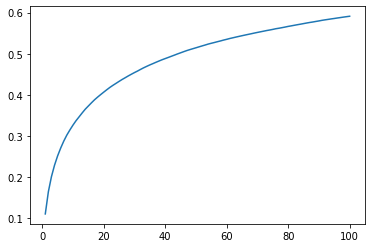

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.1109, 0.1647, 0.2013, 0.2291, 0.2517, 0.2707, 0.2876, 0.3023, 0.3148,
        0.3265, 0.3373, 0.3467, 0.3562, 0.3652, 0.3729, 0.3806, 0.3880, 0.3945,
        0.4006, 0.4066, 0.4125, 0.4181, 0.4232, 0.4280, 0.4328, 0.4374, 0.4417,
        0.4461, 0.4502, 0.4542, 0.4579, 0.4619, 0.4658, 0.4693, 0.4728, 0.4759,
        0.4792, 0.4823, 0.4854, 0.4882, 0.4909, 0.4938, 0.4966, 0.4995, 0.5022,
        0.5049, 0.5076, 0.5099, 0.5122, 0.5144, 0.5167, 0.5189, 0.5211, 0.5234,
        0.5254, 0.5272, 0.5292, 0.5311, 0.5331, 0.5349, 0.5369, 0.5386, 0.5404,
        0.5421, 0.5437, 0.5454, 0.5469, 0.5485, 0.5502, 0.5517, 0.5532, 0.5547,
        0.5563, 0.5576, 0.5591, 0.5607, 0.5619, 0.5633, 0.5647, 0.5663, 0.5676,
        0.5690, 0.5704, 0.5717, 0.5731, 0.5745, 0.5758, 0.5770, 0.5783, 0.5796,
        0.5811, 0.5823, 0.5834, 0.5845, 0.5856, 0.5867, 0.5878, 0.5889, 0.5900,
        0.5910])

In [18]:
percentages.max()

tensor(0.5910)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.52308628, 0.50575755, 0.4934049 , 0.48486504, 0.47817743,
       0.47266593, 0.46778348, 0.46380276, 0.46047371, 0.45749219,
       0.45488795, 0.45247368, 0.45011195, 0.44795854, 0.44596155,
       0.44416141, 0.44256575, 0.44091151, 0.43933816, 0.43800452,
       0.43677175, 0.43548972, 0.43429248, 0.43308896, 0.43196258,
       0.43083655, 0.42988097, 0.42888904, 0.42799994, 0.42708015,
       0.42622713, 0.4253859 , 0.42458117, 0.42377653, 0.42299728,
       0.42224558, 0.42152909, 0.42082326, 0.42014319, 0.41947394,
       0.41881371, 0.41818563, 0.41756081, 0.41697002, 0.41632361,
       0.41571801, 0.4151182 , 0.41456799, 0.41399047, 0.4134514 ,
       0.4129469 , 0.41244307, 0.41193942, 0.41144622, 0.41095775,
       0.41049453, 0.41003534, 0.40956642, 0.40911411, 0.40866014,
       0.4082196 , 0.4077846 , 0.40736838, 0.40694109, 0.40653003,
       0.40611076, 0.40569758, 0.40530992, 0.40492014, 0.4045232 ,
       0.40415498, 0.40378002, 0.40342617, 0.40307733, 0.40272

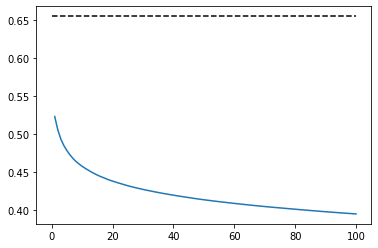

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f2e10be0840> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(18981)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.9659446284284741

In [37]:
max_k = 100
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [38]:
indices

array([[     0, 134013, 120998, ...,  80253,  63097,  57776],
       [     1, 154949,  47906, ...,  58979, 128618,  22143],
       [     2,  97601,  47369, ...,   4449, 162407, 152170],
       ...,
       [169340,  17471,  54845, ...,   8957, 105045,  97300],
       [169341,  85982, 160051, ...,  71202, 118824, 162724],
       [169342, 101430, 158981, ..., 109141,  12114,  17877]])

In [39]:
sum(emb_norm[0] * emb_norm[411])

0.9318892568569481

In [40]:
distances

array([[1.0000001 , 0.9996141 , 0.99944717, ..., 0.9979317 , 0.9979254 ,
        0.9978903 ],
       [1.0000002 , 0.99975383, 0.9896958 , ..., 0.9731744 , 0.9731723 ,
        0.97304034],
       [0.99999964, 0.9988606 , 0.9980965 , ..., 0.9907659 , 0.99075824,
        0.99067885],
       ...,
       [1.0000001 , 0.99559486, 0.9951119 , ..., 0.9626121 , 0.96246415,
        0.96240014],
       [1.0000004 , 0.9998007 , 0.9997845 , ..., 0.9990433 , 0.99904025,
        0.9990298 ],
       [1.0000002 , 0.992006  , 0.98932475, ..., 0.9458257 , 0.9455063 ,
        0.94546866]], dtype=float32)

In [41]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [42]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.]])

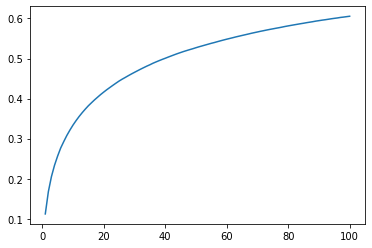

In [43]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [44]:
percentages

tensor([0.1121, 0.1677, 0.2052, 0.2334, 0.2562, 0.2765, 0.2926, 0.3078, 0.3212,
        0.3337, 0.3449, 0.3552, 0.3647, 0.3736, 0.3820, 0.3894, 0.3966, 0.4033,
        0.4100, 0.4162, 0.4221, 0.4276, 0.4332, 0.4385, 0.4437, 0.4484, 0.4527,
        0.4571, 0.4614, 0.4654, 0.4694, 0.4734, 0.4772, 0.4809, 0.4843, 0.4881,
        0.4914, 0.4946, 0.4977, 0.5006, 0.5036, 0.5065, 0.5094, 0.5122, 0.5149,
        0.5175, 0.5199, 0.5222, 0.5244, 0.5269, 0.5293, 0.5314, 0.5336, 0.5358,
        0.5379, 0.5399, 0.5421, 0.5442, 0.5462, 0.5482, 0.5501, 0.5519, 0.5539,
        0.5557, 0.5575, 0.5593, 0.5610, 0.5629, 0.5646, 0.5662, 0.5679, 0.5694,
        0.5711, 0.5726, 0.5740, 0.5755, 0.5768, 0.5784, 0.5800, 0.5814, 0.5828,
        0.5841, 0.5855, 0.5868, 0.5880, 0.5894, 0.5907, 0.5919, 0.5933, 0.5945,
        0.5957, 0.5967, 0.5979, 0.5991, 0.6002, 0.6012, 0.6025, 0.6034, 0.6044,
        0.6055])

### Percentage of same class neighbors by neighborhood size

In [45]:
ind_labels = label_transform(indices)

In [46]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [47]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [48]:
perc_same_class = n_same_class / n_total

In [49]:
perc_same_class

array([0.5277927 , 0.50886662, 0.49693029, 0.48815422, 0.48118198,
       0.47577402, 0.47146662, 0.46752006, 0.46408506, 0.46127918,
       0.45868659, 0.4563081 , 0.45417153, 0.45219719, 0.45031366,
       0.44865635, 0.44706723, 0.44558578, 0.44410457, 0.44281163,
       0.44165645, 0.44050295, 0.43937992, 0.43835022, 0.43731291,
       0.43639832, 0.43545786, 0.43456054, 0.43369965, 0.43288808,
       0.43210754, 0.43128757, 0.43051479, 0.42976316, 0.42904165,
       0.42833218, 0.42767031, 0.4270369 , 0.42636739, 0.42574154,
       0.42511626, 0.42453749, 0.423973  , 0.42341646, 0.42286536,
       0.42235671, 0.42182698, 0.42130715, 0.42082758, 0.42032408,
       0.41983488, 0.41937154, 0.41891699, 0.41843915, 0.41797771,
       0.4175451 , 0.41711409, 0.41668959, 0.41625937, 0.41586711,
       0.41545169, 0.41505949, 0.41466399, 0.41428851, 0.41388325,
       0.41350181, 0.41313933, 0.41279047, 0.41243691, 0.41208325,
       0.41175319, 0.41141401, 0.41107021, 0.41073387, 0.41040

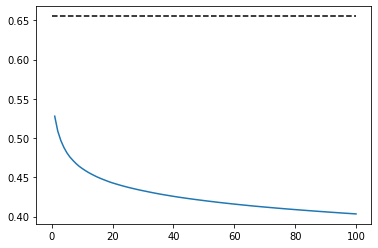

In [50]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [51]:
pca = PCA(n_components=2)

In [52]:
pca.fit(embeddings)

PCA(n_components=2)

In [53]:
emb_2d = pca.transform(embeddings)

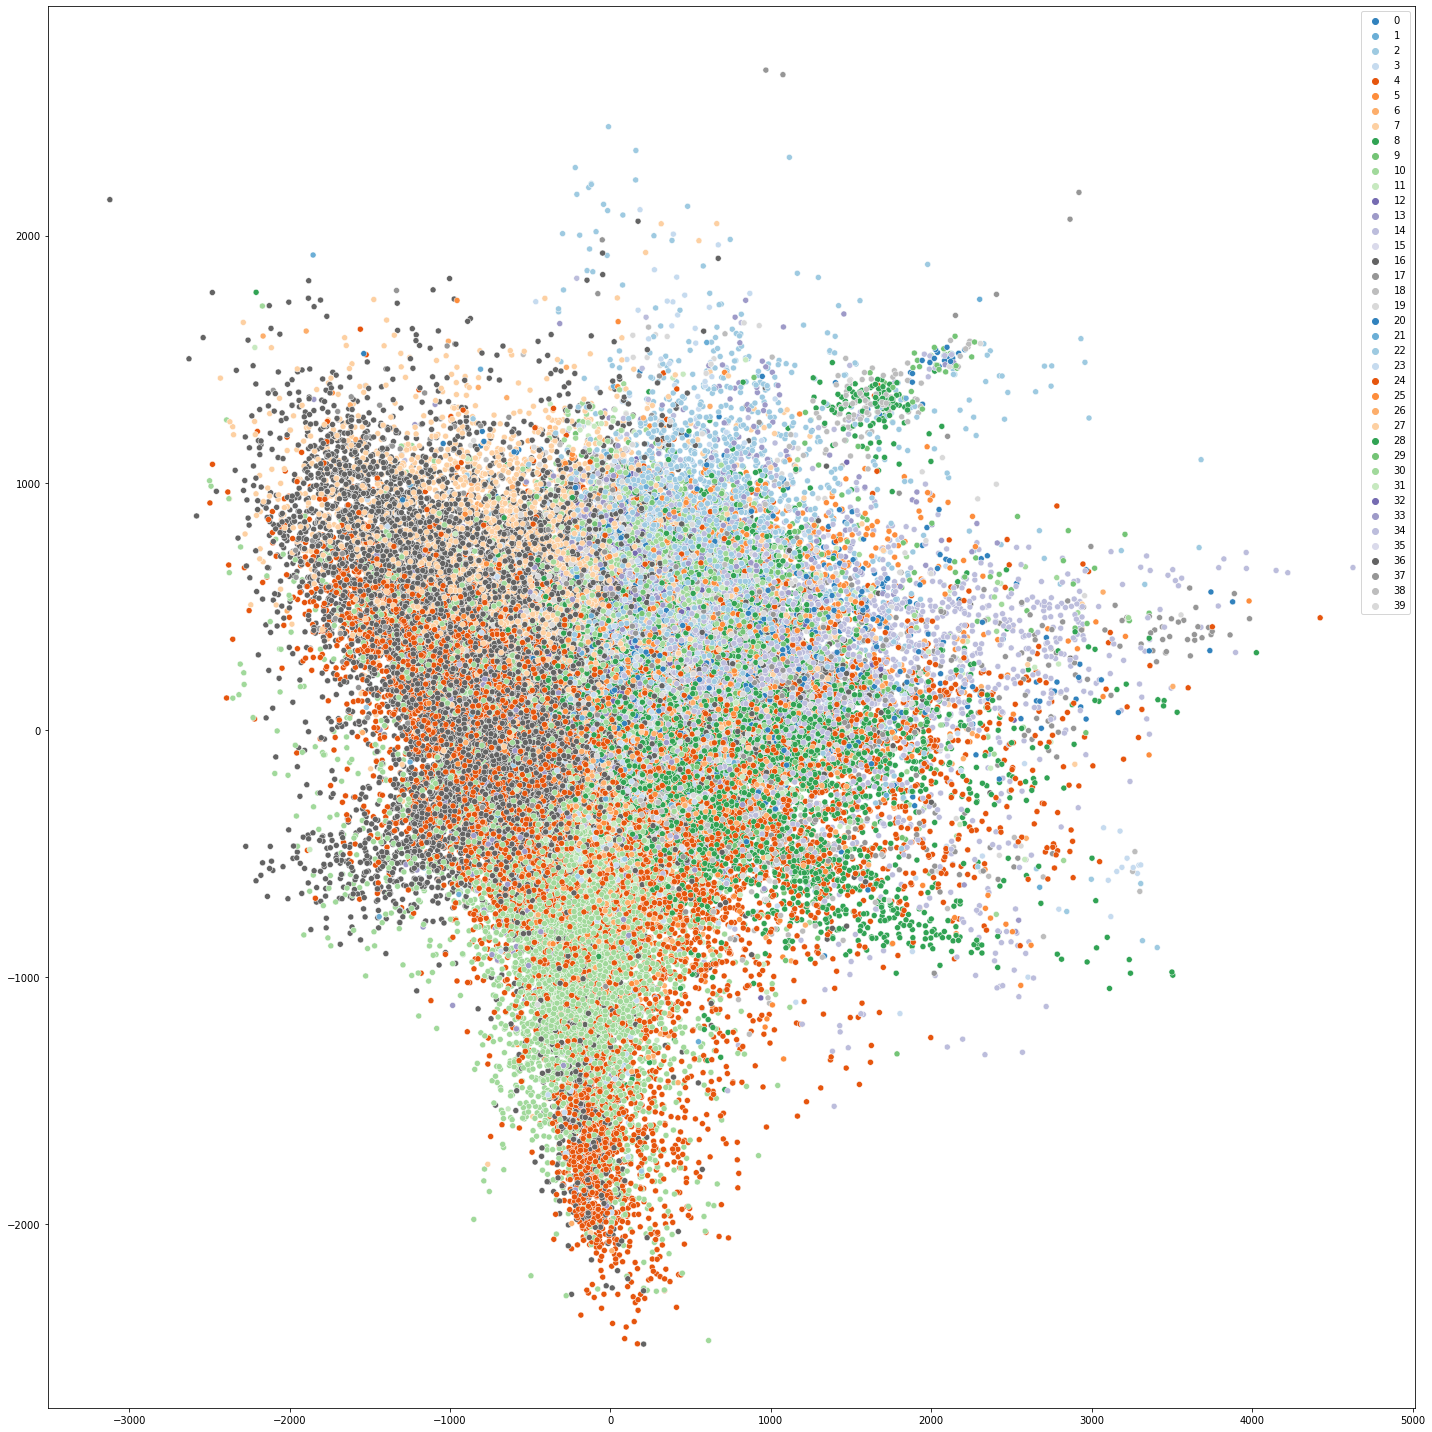

In [54]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [55]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

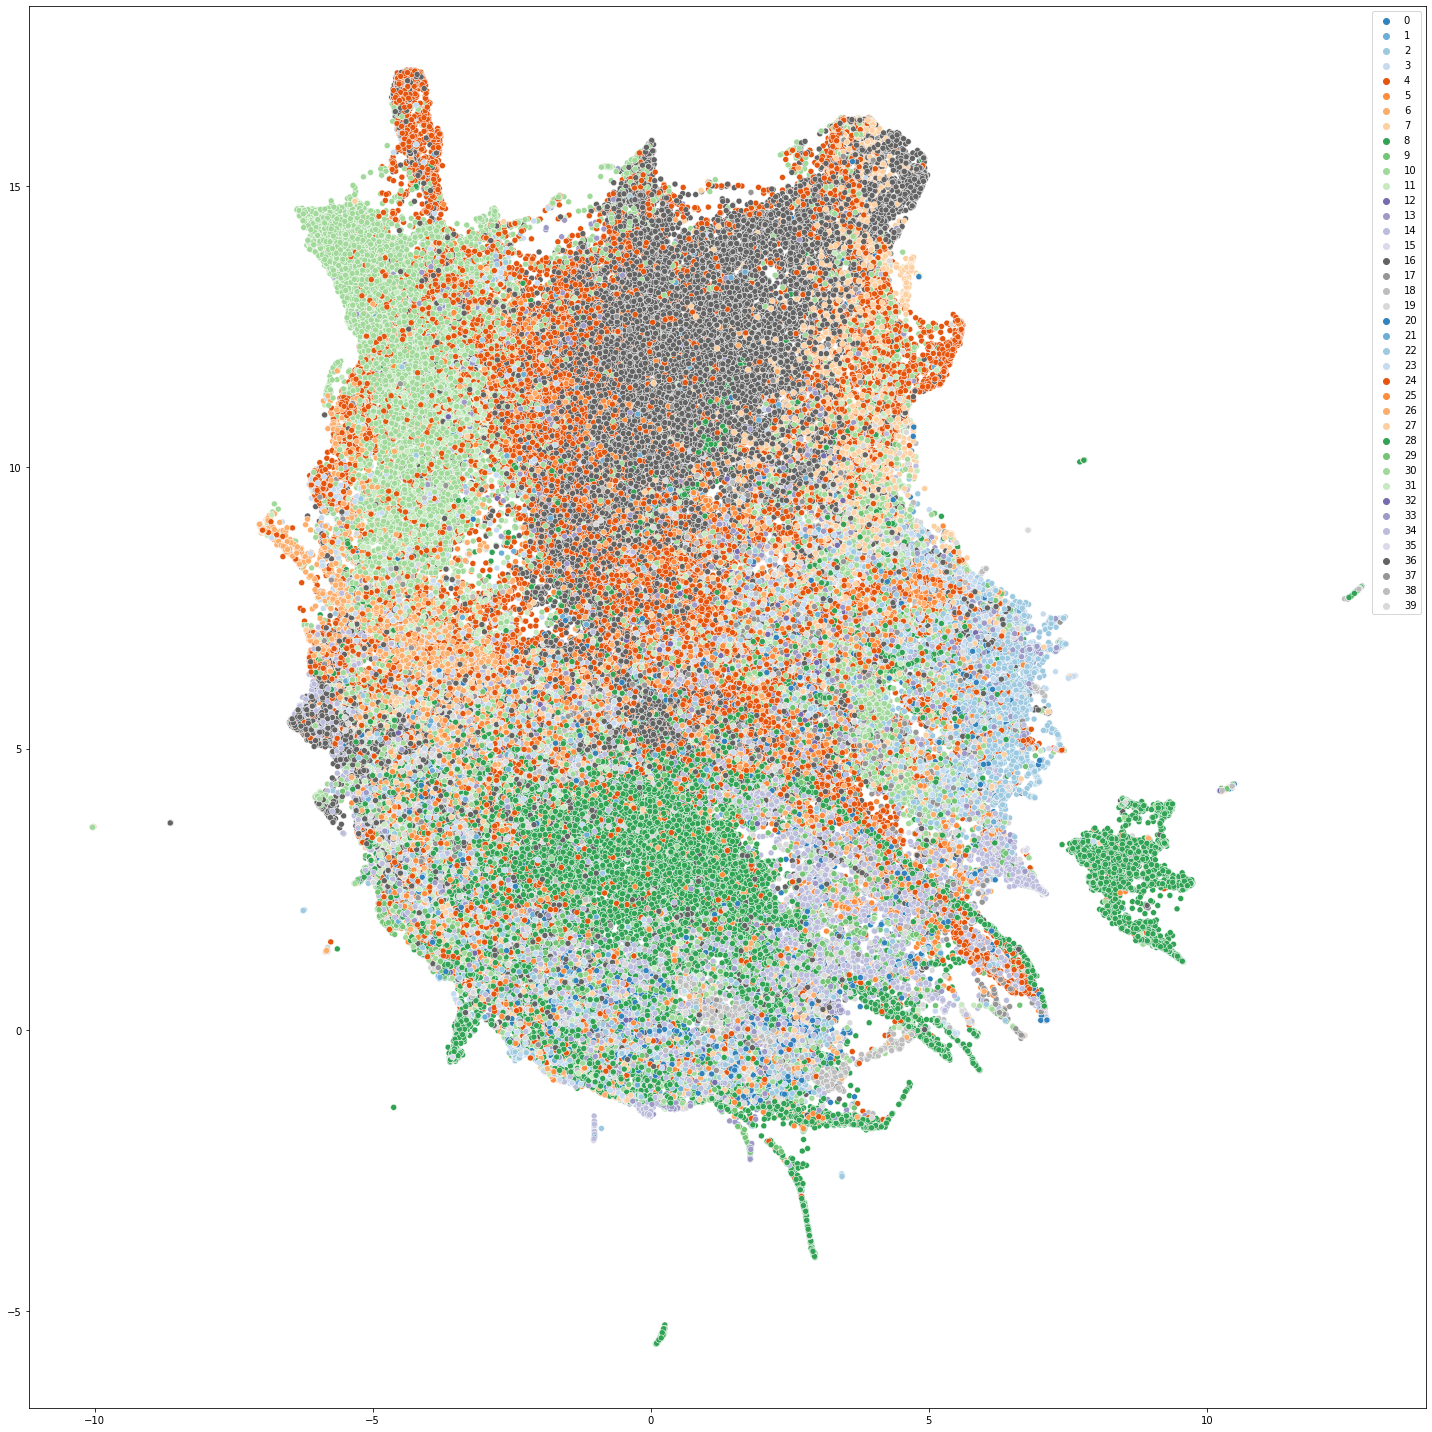

In [56]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()